In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [77]:
IMAGE_SIZE = (180,180)
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE
EPOCHS = 25

In [35]:
filenames = tf.io.gfile.glob(r'C:/Users/abdul/Desktop/CSP554_BigData/Project/archive/chest_xray/chest_xray/train/*/*')
filenames.extend(tf.io.gfile.glob(r'C:/Users/abdul/Desktop/CSP554_BigData/Project/archive/chest_xray/chest_xray/val/*/*'))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [36]:
train_normal_count = len([filename for filename in train_filenames if "NORMAL" in filename])
train_abnormal_count = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

In [37]:
train_normal_count, train_abnormal_count

(1083, 3102)

In [38]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [81]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return int(parts[-2] == "PNEUMONIA")

In [82]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [83]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [84]:
train_ds = train_list_ds.map(process_path)

val_ds = val_list_ds.map(process_path)

In [85]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [86]:
train_ds

<MapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.int32)>

In [87]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


In [88]:
test_list_ds = tf.data.Dataset.list_files(r'C:/Users/abdul/Desktop/CSP554_BigData/Project/archive/chest_xray'
                                          +'/chest_xray/test/*/*')
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

In [89]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [90]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [91]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(8,8))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

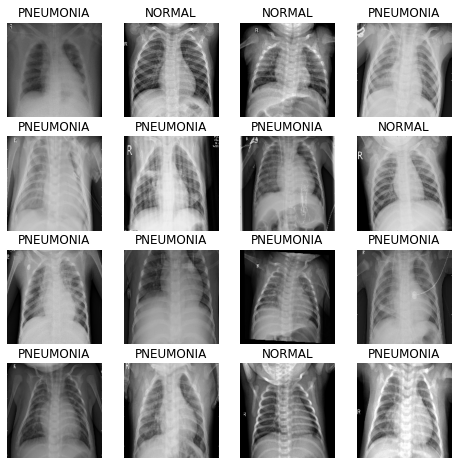

In [92]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [93]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [94]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [95]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [96]:
initial_bias = np.log([train_abnormal_count/train_normal_count])
initial_bias

array([1.0523121])

In [97]:
weight_for_0 = (1 / train_normal_count)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / train_abnormal_count)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.67


In [107]:
model = build_model()

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

In [108]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [109]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb]
)

Train for 32 steps, validate for 8 steps
Epoch 1/25
32/32 [==============================] - 19s 603ms/step - loss: 0.4452 - accuracy: 0.7739 - precision: 0.9607 - recall: 0.7245 - val_loss: 0.6912 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 2/25
32/32 [==============================] - 17s 527ms/step - loss: 0.2848 - accuracy: 0.8962 - precision: 0.9774 - recall: 0.8808 - val_loss: 0.7905 - val_accuracy: 0.7441 - val_precision: 0.7441 - val_recall: 1.0000
Epoch 3/25
32/32 [==============================] - 17s 531ms/step - loss: 0.1848 - accuracy: 0.9302 - precision: 0.9834 - recall: 0.9210 - val_loss: 0.9892 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 4/25
32/32 [==============================] - 17s 529ms/step - loss: 0.1316 - accuracy: 0.9548 - precision: 0.9894 - recall: 0.9495 - val_loss: 1.3017 - val_accuracy: 0.7451 - val_precision: 0.7451 - val_recall: 1.0000
Epoch 5/25
32/32 [==============================] - 17s 529